In [1]:
!pip install -q sentence-transformers scikit-learn pandas matplotlib nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import nltk
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from google.colab import files

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)           # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()      # Normalize whitespace
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

In [6]:
uploaded = files.upload()  # Upload a CSV file named new_data.csv
df = pd.read_csv("synthetic_resumes_200.csv")
df.fillna("", inplace=True)

# Preprocess text columns
df['job_description'] = df['job_description'].apply(preprocess)
df['cv_text'] = df['cv_text'].apply(preprocess)


Saving synthetic_resumes_200.csv to synthetic_resumes_200 (1).csv


In [7]:
examples = [
    InputExample(texts=[row['job_description'], row['cv_text']], label=float(row['label'] or 0.0))
    for _, row in df.iterrows()
]


In [8]:
model = SentenceTransformer('all-mpnet-base-v2')

# Create dataloaders
train_dataloader = DataLoader(examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

# 10% validation set
val_examples = examples[:int(0.1 * len(examples))]
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_examples)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=5,
    evaluation_steps=100,
    warmup_steps=100,
    show_progress_bar=True,
    output_path="./best_model"
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muntakimulislam (muntakimulislam-cuet) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
13,No log,No log,nan,nan
26,No log,No log,nan,nan
39,No log,No log,nan,nan
52,No log,No log,nan,nan
65,No log,No log,nan,nan


/usr/local/lib/python3.11/dist-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:203: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_pearson, _ = pearsonr(labels, scores)
/usr/local/lib/python3.11/dist-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:204: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_spearman, _ = spearmanr(labels, scores)
/usr/local/lib/python3.11/dist-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:203: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_pearson, _ = pearsonr(labels, scores)
/usr/local/lib/python3.11/dist-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:204: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_spearman, _ = spearmanr(labels, scores)


In [9]:
true_scores = [ex.label for ex in val_examples]
pred_scores = [
    util.cos_sim(model.encode(ex.texts[0], convert_to_tensor=True),
                 model.encode(ex.texts[1], convert_to_tensor=True)).item()
    for ex in val_examples
]

# Regression metrics
mae = mean_absolute_error(true_scores, pred_scores)
r2 = r2_score(true_scores, pred_scores)

# Binarize for classification metrics
true_binary = [1 if s >= 0.5 else 0 for s in true_scores]
pred_binary = [1 if s >= 0.5 else 0 for s in pred_scores]
acc = accuracy_score(true_binary, pred_binary)
f1 = f1_score(true_binary, pred_binary)

print("\n🔍 Evaluation Metrics on Validation Set:")
print(f"MAE: {mae:.4f}, R2: {r2:.4f}")
print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")



🔍 Evaluation Metrics on Validation Set:
MAE: 0.0108, R2: 0.0000
Accuracy: 1.0000, F1 Score: 1.0000


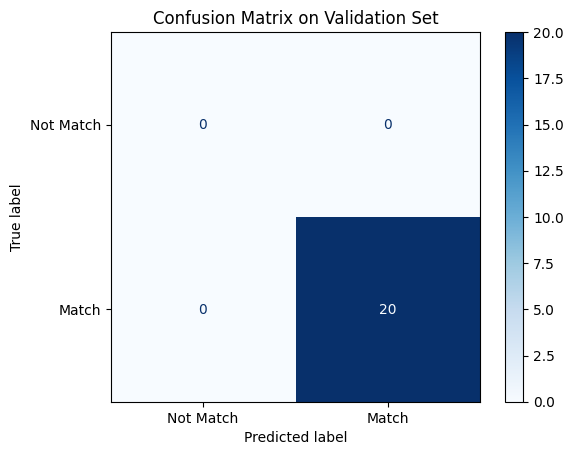

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [0, 1]  # Ensure both classes are shown
cm = confusion_matrix(true_binary, pred_binary, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Match", "Match"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [18]:
print("\n📝 Enter CVs (type 'exit' to stop):")
user_cvs = []
while True:
    cv = input(f"CV {len(user_cvs)+1}: ")
    if cv.lower() == 'exit':
        break
    user_cvs.append(preprocess(cv))

job_desc = preprocess(input("\n🧑‍💼 Job description: "))

# Load fine-tuned model
model = SentenceTransformer('./best_model')

job_embedding = model.encode(job_desc, convert_to_tensor=True)

ranked = []
for cv_text in user_cvs:
    cv_embedding = model.encode(cv_text, convert_to_tensor=True)
    score = util.cos_sim(job_embedding, cv_embedding).item()
    ranked.append((cv_text, score))

ranked = sorted(ranked, key=lambda x: x[1], reverse=True)


📝 Enter CVs (type 'exit' to stop):
CV 1: Md. Hasan is a Computer Science graduate with strong expertise in Python, TensorFlow, and Machine Learning. He has completed several projects including a deep learning system for medical image classification and has internship experience at a tech startup. His specialization is Artificial Intelligence with a keen interest in NLP and Data Science.
CV 2: Shamima Akter is a UI/UX designer with experience in Figma, Adobe XD, HTML, and CSS. She graduated from the Design and Multimedia department and has worked on several user interface projects for mobile applications. She specializes in Frontend Design and User Experience.
CV 3: Tanvir Ahmed is a software engineer with strong programming skills in Java, Python, and C++. He graduated from the Computer Science department and has a solid foundation in algorithms and data structures. He is passionate about Machine Learning and has built several classification models.
CV 4: Farzana Yasmin is an electric

In [19]:
print("\n📊 Ranked CVs for the Job:\n")
print("| Rank | CV Text (Preview)                                | Suitability Score |")
print("|------|--------------------------------------------------|-------------------|")
for i, (cv_text, score) in enumerate(ranked, 1):
    print(f"| {i:<4} | {cv_text[:50]:<50} | {score:.2f}              |")



📊 Ranked CVs for the Job:

| Rank | CV Text (Preview)                                | Suitability Score |
|------|--------------------------------------------------|-------------------|
| 1    | md hasan computer science graduate strong expertis | 0.33              |
| 2    | tanvir ahmed software engineer strong programming  | 0.30              |
| 3    | farzana yasmin electrical engineer interests embed | 0.24              |
| 4    | kamal uddin data analyst experience sql excel powe | 0.19              |
| 5    | shamima akter uiux designer experience figma adobe | 0.15              |


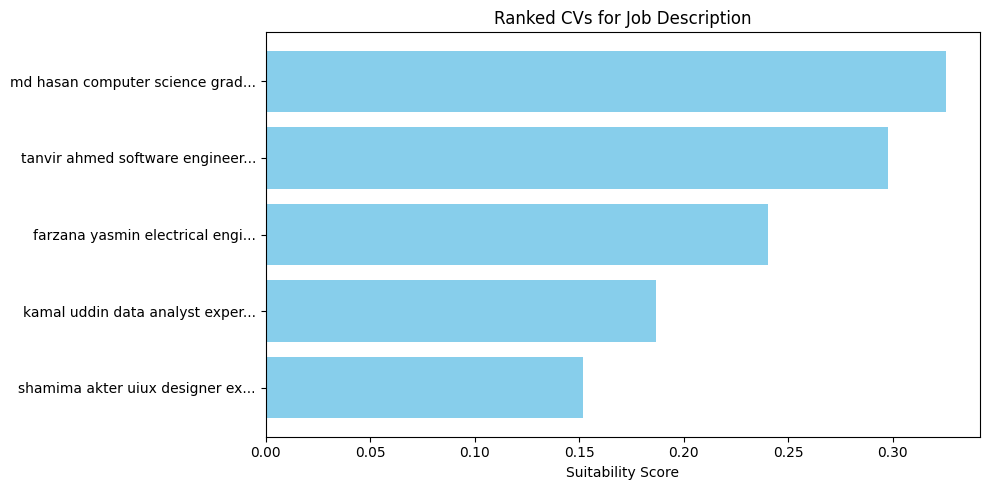

In [20]:
texts = [cv[:30] + "..." for cv, _ in ranked]
scores = [score for _, score in ranked]

plt.figure(figsize=(10, 5))
plt.barh(texts[::-1], scores[::-1], color='skyblue')
plt.xlabel('Suitability Score')
plt.title('Ranked CVs for Job Description')
plt.tight_layout()
plt.show()
